# CS 480/680 Assignment 4

## Exercise 2

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erf
from dataclasses import dataclass

PLOT_DIR = 'plot/ex2'

if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

@dataclass
class Hyperparameter:
    lambda_: float = 0.5
    mu = [1., -1.]
    sigma = [0.5, 0.5]

gmm = Hyperparameter()

### Q1

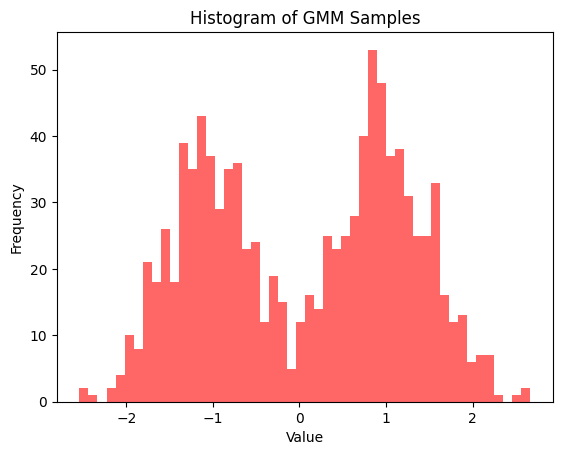

In [2]:
def GMMsample(gmm, n=1000, b=50):
    lambda_ = gmm.lambda_
    mu = gmm.mu
    sigma = gmm.sigma

    samples = np.zeros(n)

    # Sample from Uniform(0, 1)
    U = np.random.uniform(0, 1, n)

    # Decide which Gaussian to sample from
    mask = U < lambda_
    samples[mask] = np.random.normal(mu[0], sigma[0], mask.sum())
    samples[~mask] = np.random.normal(mu[1], sigma[1], (~mask).sum())

    # Plot the histogram
    plt.hist(samples, bins=b, alpha=0.6, color='r')
    plt.title('Histogram of GMM Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.savefig(f'{PLOT_DIR}/GMMsample.png')
    plt.show()

    return samples


X = GMMsample(gmm, n=1000, b=50)

### Q2

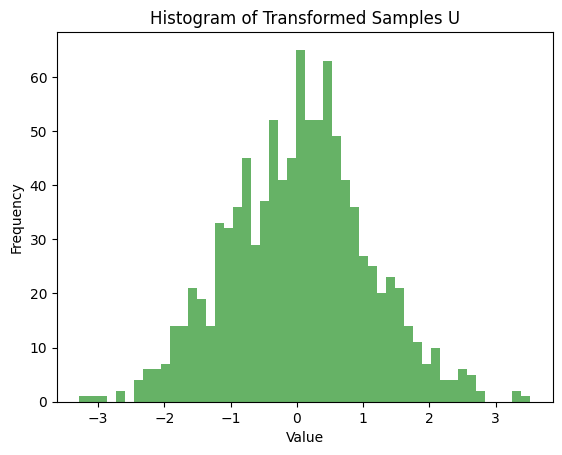

In [3]:
def GMM_CDF(x, lambda_, mu, sigma):
    F1 = 0.5 * (1 + erf((x - mu[0]) / (sigma[0] * np.sqrt(2))))
    F2 = 0.5 * (1 + erf((x - mu[1]) / (sigma[1] * np.sqrt(2))))
    return lambda_ * F1 + (1 - lambda_) * F2


def GMMinv(X, gmm, b=50, filename='GMMinv.png'):
    lambda_ = gmm.lambda_
    mu = gmm.mu
    sigma = gmm.sigma

    # inverse CDF, Phi^{-1}
    Phi_inv = norm.ppf

    # Compute the transformed samples Usf_i
    U = Phi_inv(GMM_CDF(X, lambda_, mu, sigma))

    # Plot the histogram
    if filename == 'GMMinv.png':
        color = 'g'
    else:
        color = 'y'
    plt.hist(U, bins=b, alpha=0.6, color=color)
    plt.title('Histogram of Transformed Samples U')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.savefig(f'{PLOT_DIR}/{filename}')
    plt.show()

    return U


U = GMMinv(X, gmm, b=50)

### Q3

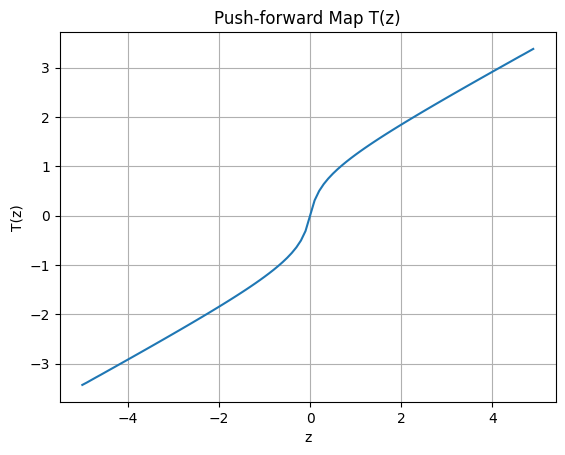

In [4]:
def BinarySearch(F, u, lb=-100, ub=100, maxiter=100, tol=1e-8):
    while F(lb) > u:  # lower bound too large
        ub = lb
        lb *= 2
    while F(ub) < u:  # upper bound too small
        lb = ub
        ub *= 2

    for _ in range(maxiter):
        x = (lb + ub) / 2  # midpoint
        t = F(x)

        if t > u:
            ub = x
        else:
            lb = x

        if abs(t - u) <= tol:
            break

    return x


def T(z, gmm):
    lambda_ = gmm.lambda_
    mu = gmm.mu
    sigma = gmm.sigma

    Phi = norm.cdf

    def GMM_CDF_wrapped(x):
        return GMM_CDF(x, lambda_, mu, sigma)

    return BinarySearch(GMM_CDF_wrapped, Phi(z))


def plot_T(gmm, z_range, increment=0.1):
    z_values = np.arange(z_range[0], z_range[1], increment)
    T_values = [T(z, gmm) for z in z_values]

    plt.plot(z_values, T_values)
    plt.title('Push-forward Map T(z)')
    plt.xlabel('z')
    plt.ylabel('T(z)')
    plt.grid(True)
    plt.savefig(f'{PLOT_DIR}/T.png')
    plt.show()


# Plot the function T(z) for z in [-5, 5]
plot_T(gmm, z_range=[-5, 5])

### Q4

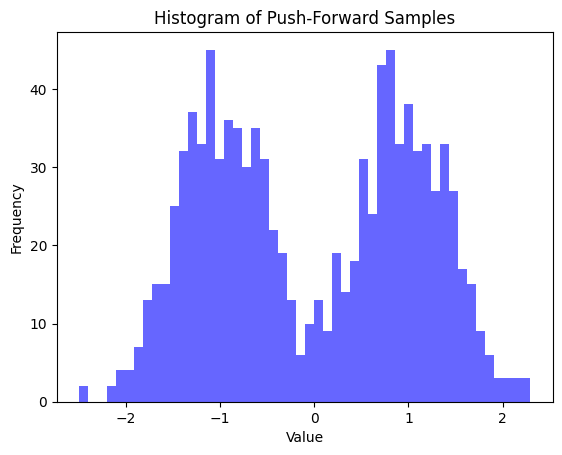

In [5]:
def PushForward(Z, gmm, b=50):
    T_values = np.array([T(z, gmm) for z in Z])

    # Plot the histogram
    plt.hist(T_values, bins=b, alpha=0.6, color='b')
    plt.title('Histogram of Push-Forward Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.savefig(f'{PLOT_DIR}/PushForward.png')
    plt.show()

    return T_values


# Sample Z from standard normal distribution
n = 1000
Z = np.random.normal(0, 1, n)

# Compute and plot the push-forward samples
tilde_X = PushForward(Z, gmm)

### Q5

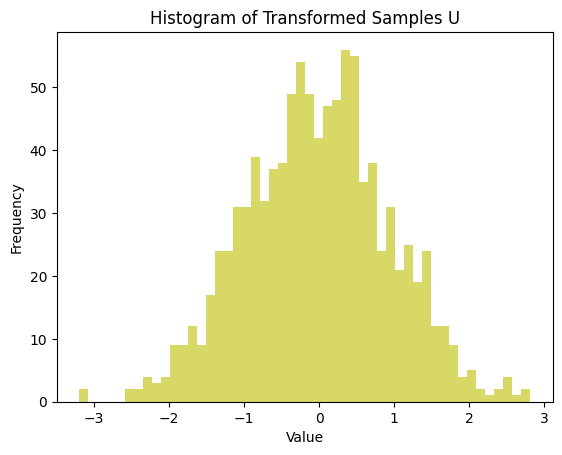

In [6]:
# Compute and plot the transformed samples
tilde_U = GMMinv(tilde_X, gmm, b=50, filename='tilde_U.png')